## **Dataset**

**4 Videos in .mp4 format**

In [1]:
import kagglehub


path = kagglehub.dataset_download("talpeer/br-videos")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/br-videos


### Create the required directory structure

In [78]:
# !mkdir /kaggle/working/br-videos

## **Imports & installations**

In [ ]:
installes_needed = True
if installes_needed:
    !pip install ultralytics
    !pip install av
    !pip install deep-sort-realtime
    !pip install torchreid

In [46]:
import os
from collections import defaultdict
from glob import glob
import json
import random
import time
from tqdm import tqdm
from datetime import datetime


import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from skimage.feature import hog, local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

import networkx as nx
import av
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

import PIL
import torch
import cv2
from ultralytics import YOLO
import torchreid


from torchvision import models, transforms
from torchvision.io import read_video
from torchvision.datasets import VisionDataset

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

np.random.seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device --> {device}")

pd.set_option('display.max_rows', 50)

Device --> cuda


In [3]:
def extract_key_frames(video_path, num_key_frames=5, diff_threshold=10):
    """
    Key frames are frames which demonstrated significant l1 difference between the previous frame.
    This function return the frames in array for later tensor stack.
    :param video_path: video path
    :param num_key_frames: number of key frames to create
    :param diff_threshold: threshold set to define a significant "change" in video
    :return: Key frames
    """
    cap = cv2.VideoCapture(video_path)
    ret, prev_frame = cap.read()

    if not ret:
        raise ValueError(f"Error reading video {video_path}")

    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    key_frames = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(frame_gray, prev_frame_gray)
        diff_sum = np.sum(frame_diff)

        if diff_sum > diff_threshold:
            key_frames.append(frame)
            frame_count += 1
            if frame_count >= num_key_frames:
                break

        prev_frame_gray = frame_gray

    cap.release()

    if len(key_frames) < num_key_frames:
        key_frames += [key_frames[-1]] * (num_key_frames - len(key_frames))

    return key_frames


def load_video_frames(video_path, num_frames=30):
    """
    Converting each frame to numpy array and append to list
    :param video_path: Video to create frames for
    :param num_frames: number of frames to create
    :return: a list of frames
    """
    container = av.open(video_path)
    frames = []
    for frame in container.decode(video=0):
        if len(frames) >= num_frames:
            break

        img = frame.to_ndarray(format='rgb24')
        frames.append(img)
    return frames

In [17]:
def extract_key_frames_adaptive(video_path, max_frames=500, k=1.25,save_to_output=False,out_dir="/kaggle/working/keyframes"):
    """
    מחזירה key frames על בסיס סף אדפטיבי (mean + k*std) של הבדלים בין פריימים.
    :param video_path: מסלול הווידאו
    :param max_frames: מספר key frames שנחזיר
    :param k: מקדם לסטיית תקן (למשל 2.0)
    :return: רשימת פריימים שנבחרו
    """
    clip_id = os.path.splitext(os.path.basename(video_path))[0]
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_duration = 1.0 / fps 
    print(f"Frame rate FPS: {frame_rate}")
    
    ret, prev_frame = cap.read()
    if not ret:
        raise ValueError(f"Error reading video {video_path}")

    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    diffs = []
    frames_gray = []
    orig_frames = []
    records = []
    frame_idx = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        orig_frames.append(frame)
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(frame_gray, prev_frame_gray)
        diff_sum = np.sum(frame_diff)
        diffs.append(diff_sum)
        frames_gray.append((frame, diff_sum))
        prev_frame_gray = frame_gray
                
        start_time = frame_idx / fps
        end_time = start_time + frame_duration
        records.append({
        "clip_id": clip_id,
        "frame_index": frame_idx,
        "start_time_sec": round(start_time, 3),
        "end_time_sec": round(end_time, 3)
        })

        frame_idx += 1
        
    cap.release()

    if len(diffs) == 0:
        return []

    mean_val = np.mean(diffs)
    std_val = np.std(diffs)
    threshold = mean_val + (k * std_val)

    orig_frames_count = len(orig_frames)
    key_frames_grey = [i for i,(frame, d) in enumerate(frames_gray) if (d >= threshold or i==0)]
    key_frames = []
    
    for i in key_frames_grey:
        key_frames.append(orig_frames[i])
    records = [rec for rec in records if rec["frame_index"] in key_frames_grey]
    print(f"Original frames count: {orig_frames_count} | output frames count: {len(key_frames)} (dropped {orig_frames_count-len(key_frames)} frames.)")    
    if len(key_frames) > max_frames:
        key_frames = key_frames[:max_frames]
        
    if save_to_output:
        saved_paths = save_key_frames(video_path, key_frames, out_dir = out_dir)
    return key_frames, records
    
def extract_key_frames_topk(video_path, max_frames=400,save_to_output=False,k=None,out_dir="/kaggle/working/keyframes"):
    clip_id = os.path.splitext(os.path.basename(video_path))[0]
    
    cap = cv2.VideoCapture(video_path)
    
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_duration = 1.0 / fps 
    print(f"Frame rate FPS: {fps}")
    
    ret, prev_frame = cap.read()
    if not ret:
        raise ValueError(f"Error reading video {video_path}")

    prev_frame_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    
    records = []
    diffs = []
    frames_all = []

    frame_idx = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break

                              
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame_diff = cv2.absdiff(frame_gray, prev_frame_gray)
        diff_val = np.sum(frame_diff)  # נורמליזציה לפי מספר פיקסלים
        diffs.append((diff_val, frame_idx, frame))
        prev_frame_gray = frame_gray

        start_time = frame_idx / fps
        end_time = start_time + frame_duration
        
        records.append({
        "clip_id": clip_id,
        "frame_index": frame_idx,
        "start_time_sec": round(start_time, 3),
        "end_time_sec": round(end_time, 3)
        })

        
        
        frame_idx += 1
    cap.release()

    if len(diffs) == 0:
        return []

    diffs_sorted = sorted(diffs, key=lambda x: x[0], reverse=True)
    topk = diffs_sorted[:max_frames]
    topk_sorted_by_frame = sorted(topk, key=lambda x: x[1])
    key_frames = [frame for _, _, frame in topk_sorted_by_frame]
    chosen_frames = [frame_idx for _, frame_idx, _ in topk_sorted_by_frame]
    records = [rec for rec in records if rec["frame_index"] in chosen_frames]
    print(f"Original frames count: {frame_idx + 1} | output frames count: {len(key_frames)} (dropped {frame_idx + 1 - len(key_frames)} frames.)")    

    if save_to_output:
        saved_paths = save_key_frames(video_path, key_frames, out_dir = out_dir)
    return key_frames, records

def save_key_frames(video_path, key_frames, out_dir = "/kaggle/working/keyframes"):
    video_id = os.path.basename(video_path).split(".")[0]
    out_dir = f"{out_dir}/{video_id}"
    
    os.makedirs(out_dir, exist_ok=True)
    saved_paths = []

    for idx, frame in enumerate(key_frames):
        frame_path = os.path.join(out_dir, f"{video_id}_keyframe_{idx:03d}.jpg")
        cv2.imwrite(frame_path, frame)
        saved_paths.append(frame_path)
    return saved_paths


In [11]:
model_loader = "no_torch" #"torch"

if model_loader == "torch":
    model_name = "yolov5"
    #model = torch.hub.load("ultralytics/yolov5", "yolov5s", pretrained=True)
else:
    model_name = "yolo11n"
    model = YOLO(f"{model_name}.pt")

embd_metric = "cosine"
embd_eps = 0.693
detect_conf = 0.5
store_output = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [20]:
from ultralytics import YOLO
import torchreid
from deep_sort_realtime.deepsort_tracker import DeepSort
from torchreid.reid.utils import FeatureExtractor
from sklearn.cluster import DBSCAN, OPTICS
# from sklearn.cluster import HDBSCAN


def get_clip(clip_id):
    clip_path = f"/kaggle/input/br-videos/{clip_id}.mp4"
    return clip_path

def show_image(img, resize_scale = 0.5):
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (int(w*resize_scale), int(h*resize_scale)))
    success, encoded_image = cv2.imencode('.jpg', img_resized)
    display(Image(data=encoded_image.tobytes()))

def apply_transform(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # המרה ל־RGB
    img = PIL.Image.fromarray(img)    

    transform = transforms.Compose([
    transforms.Resize((256, 128)),  # גודל סטנדרטי ל-ReID
    transforms.ToTensor(),          # הופך ל־tensor עם ערכים בין 0 ל־1
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # הממוצעים של ImageNet
        std=[0.229, 0.224, 0.225]   # הסטיות התקן של ImageNet
    )])

    return transform(img)

def extract_all_frames(video_path, save_to_output, out_dir):
    """
    שומר את כל הפריימים מתוך וידאו (לא רק המשמעותיים).
    :param video_path: נתיב לקובץ הווידאו
    :param save_to_output: האם לשמור כקבצי תמונה
    :param out_dir: תיקיית יעד לשמירה
    :return: רשימת פריימים (numpy arrays)
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise ValueError(f"Error reading video {video_path}")

    frames_all = []
    frame_idx = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frames_all.append(frame)
        frame_idx += 1

    cap.release()

    print(f"Extracted total {frame_idx} frames from {os.path.basename(video_path)}")

    saved_paths = []
    if save_to_output:
        video_name = os.path.splitext(os.path.basename(video_path))[0]
        out_path = os.path.join(out_dir, video_name)
        os.makedirs(out_path, exist_ok=True)

        for i, frame in enumerate(frames_all):
            frame_path = os.path.join(out_path, f"{video_name}_frame_{i:04d}.jpg")
            cv2.imwrite(frame_path, frame)
            saved_paths.append(frame_path)

        print(f"Saved {len(saved_paths)} frames to {out_path}")

    return frames_all


In [13]:
num_clips = 4
max_key_frames = 500
k = - 0.01
save_to_output = True
topk = True
whole_frames = False

root_dir = "/kaggle/working/keyframes" if topk else "/kaggle/working/keyframes_adp"
if whole_frames:
    root_dir = "/kaggle/working/whole_frames"
clips_ids = range(1, num_clips + 1)

track_conf = 0.6 # best 0.6
track_classes = [0]
track_stride = 5 # best 3
yolo_iou = 0.55 # best 0.5

pca_n_components = 256

In [21]:
def create_key_frames(num_clips ,max_key_frames=400,k=1.5, save_to_output = False, topk=False,out_dir="/kaggle/working/keyframes"):
    clips_ids = range(1, num_clips+1)
    db_key_frames = {f"{clip_id}":None for clip_id in clips_ids}
    all_records = []
    
    if topk:
        extractor = extract_key_frames_topk
    else:
        extractor = extract_key_frames_adaptive
    for clip_id in clips_ids:
        video_path = get_clip(clip_id = clip_id)
        db_key_frames[f"{clip_id}"], records_i = extractor(video_path,k=k, save_to_output = save_to_output,max_frames=max_key_frames,out_dir=out_dir)
        all_records.extend(records_i)
    frames_df = pd.DataFrame(all_records)
    file_name = f"top_{max_key_frames}_frames.csv" if topk else f"adaptive_{k}_frames.csv"
    frames_df.to_csv(f"/kaggle/working/{file_name}")
    return db_key_frames,frames_df


if not whole_frames:
    print(f"Extracting key frames... (TOP K = {topk})")
    create_key_frames(num_clips = num_clips, k = k, save_to_output = save_to_output, topk=topk,max_key_frames = max_key_frames,out_dir=root_dir)
else:
    db_frames = {f"{clip_id}":None for clip_id in clips_ids}
    
    for clip_id in clips_ids:
        video_path = get_clip(clip_id = clip_id)
        db_frames[f"{clip_id}"] = extract_all_frames(video_path, save_to_output = save_to_output,out_dir=root_dir)
    
for clip_id in clips_ids:
    frames_dir = os.path.join(root_dir, str(clip_id))
    frame_files = sorted(glob(os.path.join(frames_dir, "*.jpg")))
    print(f"Clip {clip_id}: Found {len(frame_files)} frames.")

# frames_dir = os.path.join(root_dir, str(clip_id))
# frame_files = sorted(glob(os.path.join(frames_dir, "*.jpg")))
# print(f"{frame_files[8]}")

Extracting key frames... (TOP K = True)
Frame rate FPS: 29.97002997002997
Original frames count: 658 | output frames count: 500 (dropped 158 frames.)
Frame rate FPS: 29.97002997002997
Original frames count: 1072 | output frames count: 500 (dropped 572 frames.)
Frame rate FPS: 29.97002997002997
Original frames count: 602 | output frames count: 500 (dropped 102 frames.)
Frame rate FPS: 29.97002997002997
Original frames count: 848 | output frames count: 500 (dropped 348 frames.)
Clip 1: Found 500 frames.
Clip 2: Found 500 frames.
Clip 3: Found 500 frames.
Clip 4: Found 500 frames.


In [15]:
def plot_crops_clustering(person_crops, cluster,person_id):
   
    if len(person_crops) > 10:
        sampled_crops = random.sample(person_crops, 10)
    else:
        sampled_crops = person_crops

    fig, axes = plt.subplots(1, len(sampled_crops), figsize=(3*len(sampled_crops), 3))
    if len(sampled_crops) == 1:
        axes = [axes] 
    for ax, crop in zip(axes, sampled_crops):
        ax.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
        ax.axis("off")
    plt.suptitle(f"Cluster {cluster} | Person ID {person_id}",fontweight="bold",fontsize=14)
    plt.show()

def display_clusters(chosen_clusters):
    for cluster_id, persons_ids_list in chosen_clusters.items():
        if cluster_id == -1:
            continue
        for person_id in persons_ids_list:
            person_crops = id_crops[person_id]
            plot_crops_clustering(person_crops,cluster_id,person_id)

In [47]:
extractor = FeatureExtractor(
    model_name="osnet_ain_x1_0",
    model_path=None,
    device= device 
)

def get_embedding(crop, add_extra_features=False,include_hog=False):
    img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    deep_feat = extractor([img_rgb])[0].cpu().numpy()
    if add_extra_features:
        hist = get_hist_features(crop)
        if not include_hog:
            extra_feat = np.concatenate([deep_feat, hist])
        else:
            hog_feat = get_hog_features(crop)
            extra_feat = np.concatenate([deep_feat, hog_feat, hist])
        extra_feat = extra_feat / np.linalg.norm(extra_feat)
        return extra_feat
        
    deep_feat = deep_feat / np.linalg.norm(deep_feat)
    return deep_feat

def get_hist_features(crop):
    gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, 8 + 3),
                             range=(0, 8 + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def get_hog_features(crop):
    img_rgb = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
    hog_feat = hog(cv2.resize(img_rgb, (128, 256)), 
                   orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2), channel_axis=-1, feature_vector=True)
    return hog_feat
    
def extract_extra_features(crop, only_hist=True):
    hist = get_hist_features(crop)
    if only_hist:
        return hist
    hog_feat = get_hog_features(crop)
    return hog_feat, hist

def unify_crops(id_crops):
    return pd.DataFrame.from_records(id_crops).groupby(0)[1].apply(list).reset_index()
    
def get_crops_embeddings(id_crops):
    rows = []
    for person_id, person_crops in id_crops.items():
        
        embs = [get_embedding(c) for c in person_crops] 
        
        mean_emb = np.mean(embs, axis=0)
        
        rows.append({
            "person_id": person_id,
            "embedding": mean_emb,
        })
        
    return pd.DataFrame(rows)

def get_crops_embeddings_single(id_crops, add_extra_features=False, include_hog=False):
    rows = []
    for person_id, person_crops in id_crops.items():
        for c in person_crops:
            # c_embedding = get_embedding(c,add_extra_features)
            c_embedding = get_embedding(c, add_extra_features=add_extra_features,include_hog=include_hog)
            rows.append({
                "person_id": person_id,
                "embedding": c_embedding
            })
        
    return pd.DataFrame(rows)

def calc_cluster_size(df,calc_by="person_id",method="median", q=0.3):
    if method == "median":
        return(int(df[calc_by].value_counts().median()))
    elif method == "min":
        return(int(df[calc_by].value_counts().min()))
    elif method == "mean":
        return(int(df[calc_by].value_counts().mean()))
    elif method == "quantile":
        return(int(df[calc_by].value_counts().quantile(q)))
    else:
        return(int(df[calc_by].value_counts().min()))



Successfully loaded imagenet pretrained weights from "/root/.cache/torch/checkpoints/osnet_ain_x1_0_imagenet.pth"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']
Model: osnet_ain_x1_0
- params: 2,193,616
- flops: 978,878,352


In [28]:

def key_frames_tracker(model_ver = "yolo11n.pt", conf_file = None, num_clips = 4,show_detection=False):
    model = YOLO(model_ver).to(device)
    
    clips_ids = [3,2,1,4] #range(1, num_clips+1)
    db_tracks = {f"{clip_id}":None for clip_id in clips_ids}
    db_crops = {f"{clip_id}":None for clip_id in clips_ids}
    id_crops = defaultdict(lambda: [])
    id_masks = defaultdict(lambda: [])
    seen_tracks = set()
    
    for clip_id in clips_ids:
        frames_dir = os.path.join(root_dir, str(clip_id))
        frame_files = sorted(glob(os.path.join(frames_dir, "*.jpg")))
        print(f"Clip {clip_id}: Found {len(frame_files)} frames.")
        
        track_history = defaultdict(lambda: [])
        
        
        for frame_idx, frame_path in enumerate(frame_files):
            frame = cv2.imread(frame_path)
            result = model.track(frame, persist = True,
                                 conf = track_conf, classes = track_classes,
                                 vid_stride = track_stride, verbose = False,iou=yolo_iou,
                                    tracker=conf_file,
                                    device=device)[0]
            if result.boxes and result.boxes.is_track:
                boxes = result.boxes.xywh.cpu()
                boxes_xyxy = result.boxes.xyxy.cpu().numpy().astype(int) 
                track_ids = result.boxes.id.int().cpu().tolist()
                track_cls = result.boxes.cls.int().cpu().tolist()
                track_confs = result.boxes.conf.float().cpu().tolist()
                masks = result.masks.data.cpu().numpy() 

                new_tracking_flag = not seen_tracks.issuperset(set(track_ids))
                
                for box,crop_coords, mask, track_id, cls in zip(boxes,boxes_xyxy, masks,track_ids,track_cls):
                    if cls in [0]: # currently just persons
                        x1, y1, x2, y2 = crop_coords
                        x, y, w, h = box
                        track = track_history[track_id]
                        track.append((float(x), float(y)))  # x, y center point
                        
                        crop = frame[y1:y2, x1:x2].copy()
                        if crop.size > 0:
                            crops = id_crops[track_id]
                            crops.append(crop) 

                        if mask is not None:
                            mask_full = (mask > 0.5).astype(np.uint8)
                            mask_resized = cv2.resize(mask_full, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
                            black_bg = np.zeros_like(frame, dtype=np.uint8)
                            person_black_bg = np.where(mask_resized[..., None] == 1, frame, black_bg)
                            crop_masked = person_black_bg[y1:y2, x1:x2]
                            if crop_masked.size > 0:
                                id_masks[track_id].append(crop_masked)
                                
                if new_tracking_flag and show_detection:
                    frame = result.plot()
                    print(f"seen_tracks: {seen_tracks}")
                    print(f"new_tracks: {set(track_ids).difference(seen_tracks)}")
                    seen_tracks = seen_tracks.union(track_ids)
                    print(f"seen_tracks updated: {seen_tracks}")
                    show_image(frame)
        

        db_tracks[f"{clip_id}"] = track_history
    return db_tracks, id_crops,id_masks

# db_tracks, id_crops = key_frames_tracker()

In [23]:
def tracker(model_ver = "yolo11n.pt", conf_file = None, num_clips = 4,show_detection=False):
    def start_track(clip_id):
        model = YOLO(model_ver).to(device)
        
        frames_dir = os.path.join(root_dir, str(clip_id))
        frame_files = sorted(glob(os.path.join(frames_dir, "*.jpg")))
        print(f"Clip {clip_id}: Found {len(frame_files)} frames.")
        
        track_history = defaultdict(lambda: [])
        id_crops = defaultdict(lambda: [])
        id_masks = defaultdict(lambda: [])
        seen_tracks = set()
        
        for frame_idx, frame_path in enumerate(frame_files):
            frame = cv2.imread(frame_path)
            result = model.track(frame, persist = True,
                                 conf = track_conf, classes = track_classes,
                                 vid_stride = track_stride, verbose = False,iou=yolo_iou,
                                    tracker=conf_file,
                                    device=device)[0]
            if result.boxes and result.boxes.is_track:
                boxes = result.boxes.xywh.cpu()
                boxes_xyxy = result.boxes.xyxy.cpu().numpy().astype(int) 
                track_ids = result.boxes.id.int().cpu().tolist()
                track_cls = result.boxes.cls.int().cpu().tolist()
                track_confs = result.boxes.conf.float().cpu().tolist()
                masks = result.masks.data.cpu().numpy() 
    
                new_tracking_flag = not seen_tracks.issuperset(set(track_ids))
                
                for box,crop_coords, mask, track_id, cls in zip(boxes,boxes_xyxy, masks,track_ids,track_cls):
                    if cls in [0]: # currently just persons
                        x1, y1, x2, y2 = crop_coords
                        x, y, w, h = box
                        track = track_history[track_id]
                        track.append((float(x), float(y)))  # x, y center point
                        
                        crop = frame[y1:y2, x1:x2].copy()
                        if crop.size > 0:
                            crops = id_crops[track_id]
                            crops.append(crop) 
    
                        if mask is not None:
                            mask_full = (mask > 0.5).astype(np.uint8)
                            mask_resized = cv2.resize(mask_full, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
                            black_bg = np.zeros_like(frame, dtype=np.uint8)
                            person_black_bg = np.where(mask_resized[..., None] == 1, frame, black_bg)
                            crop_masked = person_black_bg[y1:y2, x1:x2]
                            if crop_masked.size > 0:
                                crops_masks = id_masks[track_id]
                                crops_masks.append(crop_masked)
                                
                if new_tracking_flag and show_detection:
                    frame = result.plot()
                    print(f"seen_tracks: {seen_tracks}")
                    print(f"new_tracks: {set(track_ids).difference(seen_tracks)}")
                    seen_tracks = seen_tracks.union(track_ids)
                    print(f"seen_tracks updated: {seen_tracks}")
                    show_image(frame)
                    save_to_path = f"/kaggle/working/tracks/clip{clip_id}_frame{frame_idx}.png"
                    cv2.imwrite(save_to_path, frame)
        
        return track_history, id_crops, id_masks
            
    clips_ids = [3,2,1,4] #range(1, num_clips+1)
    db_tracks = {f"{clip_id}":None for clip_id in clips_ids}
    db_crops = {f"{clip_id}":None for clip_id in clips_ids}
    db_masks = {f"{clip_id}":None for clip_id in clips_ids}
    
    for clip_id in clips_ids:
        track_history, id_crops, id_masks = start_track(clip_id)
        db_tracks[f"{clip_id}"] = track_history
        db_crops[f"{clip_id}"] = id_crops
        db_masks[f"{clip_id}"] = id_masks
    return db_tracks, db_crops, db_masks

In [25]:
def generate_crops_df(db_crops):
    rows = []
    for clip_id, persons in db_crops.items():
        for person_id, crops in persons.items():
            for crop in crops:
                rows.append({
                    "clip_id": int(clip_id),
                    "person_id": person_id,
                    "crop": crop
                })
    
    crops_df = pd.DataFrame(rows)
    crops_df["pseudo_labels"] = crops_df["clip_id"].astype(str) + "_" + crops_df["person_id"].astype(str)
    return crops_df
    
def generate_tracks_embeddings(crops_df, add_extra_features=False, include_hog=False):
    embeddings_df = crops_df[["clip_id","person_id","pseudo_labels"]].copy()
    embeddings_df["embedding"] = crops_df["crop"].apply(lambda c:get_embedding(c,add_extra_features=add_extra_features,include_hog=include_hog))
    return embeddings_df

botsort_custom_single.yaml saved!
Clip 3: Found 500 frames.
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
seen_tracks: set()
new_tracks: {1, 2}
seen_tracks updated: {1, 2}


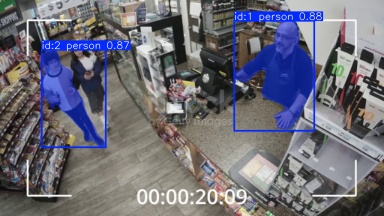

seen_tracks: {1, 2}
new_tracks: {3}
seen_tracks updated: {1, 2, 3}


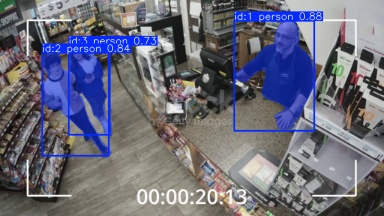

seen_tracks: {1, 2, 3}
new_tracks: {4}
seen_tracks updated: {1, 2, 3, 4}


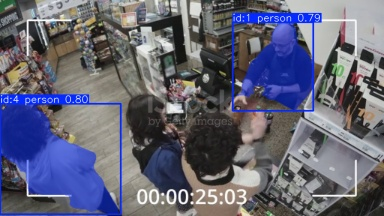

seen_tracks: {1, 2, 3, 4}
new_tracks: {5}
seen_tracks updated: {1, 2, 3, 4, 5}


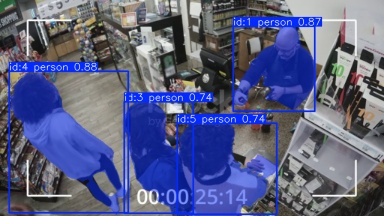

seen_tracks: {1, 2, 3, 4, 5}
new_tracks: {6}
seen_tracks updated: {1, 2, 3, 4, 5, 6}


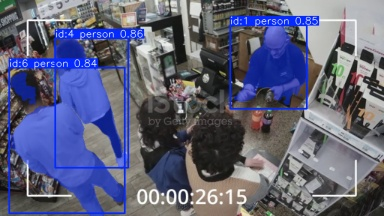

seen_tracks: {1, 2, 3, 4, 5, 6}
new_tracks: {8}
seen_tracks updated: {1, 2, 3, 4, 5, 6, 8}


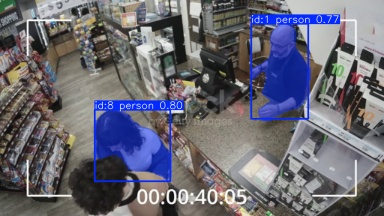

seen_tracks: {1, 2, 3, 4, 5, 6, 8}
new_tracks: {9}
seen_tracks updated: {1, 2, 3, 4, 5, 6, 8, 9}


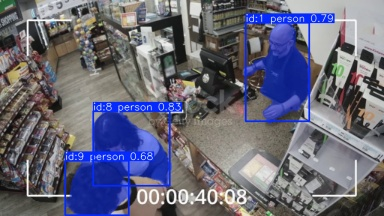

Clip 2: Found 500 frames.
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
seen_tracks: set()
new_tracks: {1}
seen_tracks updated: {1}


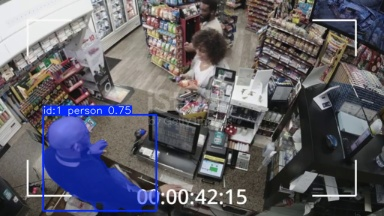

seen_tracks: {1}
new_tracks: {2}
seen_tracks updated: {1, 2}


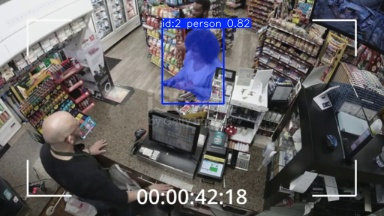

seen_tracks: {1, 2}
new_tracks: {3}
seen_tracks updated: {1, 2, 3}


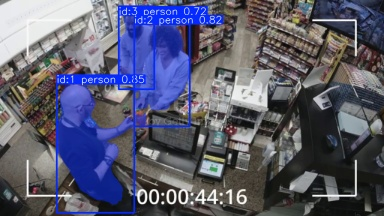

seen_tracks: {1, 2, 3}
new_tracks: {4}
seen_tracks updated: {1, 2, 3, 4}


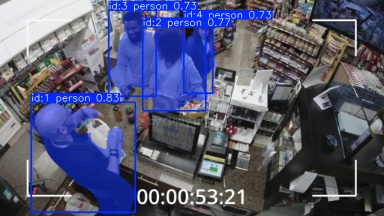

seen_tracks: {1, 2, 3, 4}
new_tracks: {5}
seen_tracks updated: {1, 2, 3, 4, 5}


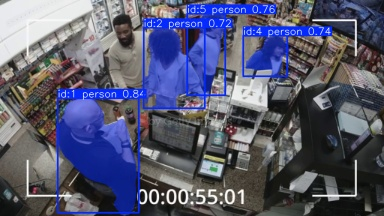

Clip 1: Found 500 frames.
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
seen_tracks: set()
new_tracks: {1, 2}
seen_tracks updated: {1, 2}


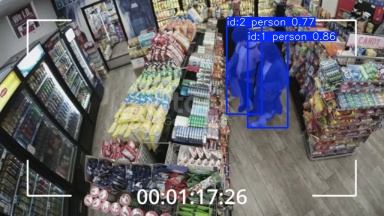

Clip 4: Found 500 frames.
WARNING ⚠️ 'source' is missing. Using 'source=/usr/local/lib/python3.11/dist-packages/ultralytics/assets'.
seen_tracks: set()
new_tracks: {1}
seen_tracks updated: {1}


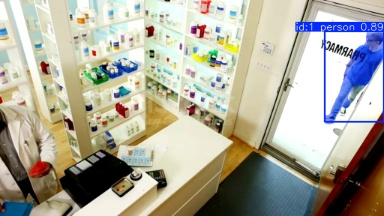

seen_tracks: {1}
new_tracks: {2}
seen_tracks updated: {1, 2}


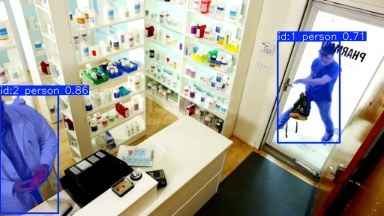

In [251]:
yaml_content_single = """
tracker_type: botsort
with_reid: True
model: yolo11n-cls.pt
track_high_thresh: 0.65
track_low_thresh: 0.2
new_track_thresh: 0.725
track_buffer: 500
match_thresh: 0.7
fuse_score: False
gmc_method: None
proximity_thresh: 0.2
appearance_thresh: 0.2
"""
#new_track_thresh: 0.7
# track_buffer: 250
# appearance_thresh: 0.3
with open("botsort_custom_single.yaml", "w") as f:
    f.write(yaml_content_single)

print("botsort_custom_single.yaml saved!")


yolo_ver = "yolo11n-seg.pt" 
conf_file = "botsort_custom_single.yaml"
db_tracks, db_crops, db_masks = tracker(model_ver = yolo_ver,conf_file =conf_file,show_detection=True)



In [290]:
crops_df = generate_crops_df(db_masks)
print(crops_df.groupby(["clip_id","person_id"]).size().sort_values(ascending=False))
embeddings_df = generate_tracks_embeddings(crops_df,add_extra_features=True, include_hog=False)

exp_extra_ftrs = False
if exp_extra_ftrs:
    for with_ext in [True,False]:
        for with_hog in [True,False]:
            embeddings_df = generate_tracks_embeddings(crops_df,add_extra_features=with_ext, include_hog=with_hog)
            print("===================================================================")
            print(f"Extra Features = {with_ext} | HoG = {with_hog}")
            # print(embeddings_df.groupby(["clip_id","person_id"]).size().sort_values(ascending=False))

clip_id  person_id
3        1            492
2        1            457
         2            456
1        1            445
4        1            436
         2            396
1        2            281
2        3            240
3        6            236
         4            104
         2             66
         3             60
2        4             23
         5             21
3        5             13
         8              4
         9              1
dtype: int64


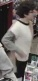

Best match for 2_5 (sim=0.7976): 1_2


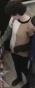

Best match for 2_4 (sim=0.7707): 1_2


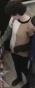

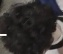

Best match for 3_9 (sim=0.7341): 1_2


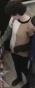

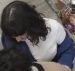

Best match for 3_8 (sim=0.7103): 1_2


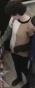

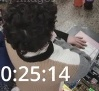

Best match for 3_5 (sim=0.7135): 1_2


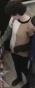

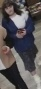

Best match for 3_3 (sim=0.7819): 1_2


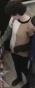

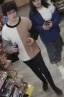

Best match for 3_2 (sim=0.767): 1_2


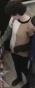

clip_id  person_id
1        1            {1_1}
         2            {1_2}
2        1            {2_1}
         2            {2_2}
         3            {2_3}
         4            {1_2}
         5            {1_2}
3        1            {3_1}
         2            {1_2}
         3            {1_2}
         4            {3_4}
         5            {1_2}
         6            {3_6}
         8            {1_2}
         9            {1_2}
4        1            {4_1}
         2            {4_2}
Name: new_pseudo_labels, dtype: object


In [293]:
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

rng = np.random.default_rng(0)

def _stack(X):
    return np.vstack(X).astype(np.float32)

def _l2norm(A, axis=1, eps=1e-9):
    n = np.linalg.norm(A, axis=axis, keepdims=True)
    return A / (n + eps)
    
def entity_similarity(Ea, Eb, metric="cosine"):
    """
    דמיון בין שתי ישויות כענני embeddingים.
    ערך קרוב ל-1 = דמיון גבוה, ערך קרוב ל-0 = שונה לגמרי.
    """
    Ea, Eb = np.vstack(Ea), np.vstack(Eb)
    dists = cdist(Ea, Eb, metric=metric)
    chamfer = 0.5 * (dists.min(axis=1).mean() + dists.min(axis=0).mean())
    return 1 - chamfer
    
def chamfer_similarity(Ea, Eb, metric="cosine", max_samples=400):
    """
    דמיון בין שתי 'התפלגויות' Embedding.
    מחזיר ערך ב-[0,1], גבוה=דומה. משתמש ב-Chamfer על תת-דגימה אקראית.
    """
    Ea = _stack(Ea); Eb = _stack(Eb)

    Ea = _l2norm(Ea); Eb = _l2norm(Eb)

    # if len(Ea) > max_samples:
    #     Ea = Ea[rng.integers(0, len(Ea), size=max_samples)]
    # if len(Eb) > max_samples:
    #     Eb = Eb[rng.integers(0, len(Eb), size=max_samples)]

    D = cdist(Ea, Eb, metric=metric)
    chamfer = 0.5 * (D.min(axis=1).mean() + D.min(axis=0).mean())
    # מיפוי למרווח דמיון: 1 - מרחק מנורמל בקירוב
    # בקוסינוס chamfer∈[0,2] (לרוב <<1). נגביל ל[0,1].
    sim = 1.0 - np.clip(chamfer, 0.0, 1.0)
    return float(sim)
    
def merge_ents(embeddings_df, min_count=20,high_counts=280, sim_threshold=0.7,max_count=450):
    merged = embeddings_df.copy()

    merged["new_pseudo_labels"] = merged["pseudo_labels"]  # עותק לשמירה על המקור
    clips = merged["pseudo_labels"].unique()

    pid_maps = {pl: pl for pl in clips}
    counts = merged.groupby("pseudo_labels").size()
    small_ids = counts[counts < min_count].sort_values().index
    big_ids = counts[(counts >= high_counts) & (counts < max_count)].index

    for pid in small_ids:
        Ea = merged[merged["pseudo_labels"] == pid]["embedding"].tolist()
        best_sim, best_match = 0, None
        q_clip, q_p = pid.split("_")
        relevant_pids = [cid for cid in big_ids if cid.split("_")[0] != q_clip]
  
        for pid2 in relevant_pids:
            Eb = merged[(merged["pseudo_labels"] == pid2)]["embedding"].tolist()
            sim = chamfer_similarity(Ea, Eb) # entity_similarity(Ea,Eb)#
            if sim > best_sim:
                best_sim, best_match = sim, pid2
                
        if best_sim >= sim_threshold:
            show_image(db_crops[q_clip][int(q_p)][0])
            print(f"Best match for {pid} (sim={round(best_sim,4)}): {best_match}")
            b_clip,b_p = best_match.split("_") 
            show_image(db_crops[b_clip][int(b_p)][0])
            print("========================================")
            pid_maps[pid] = best_match
    merged["new_pseudo_labels"] = merged["pseudo_labels"].map(pid_maps)
    #print("Merges:")
    #print(merged.groupby(["pseudo_labels"])["new_pseudo_labels"].value_counts())
    return merged,pid_maps

merged = embeddings_df.copy()
high_counts = 250
max_count = 350
#for sim,min_count in zip([0.715,0.8,0.8],[60,100,150]):
for sim,min_count in zip([0.75,0.7,0.8],[60,100,150]):
#for sim,min_count,high_count in zip([0.7,0.7,0.7],[50,50,150],[280,400,400]):
    merged,pid_maps = merge_ents(merged, min_count=min_count,high_counts=high_counts, sim_threshold=sim, max_count =max_count)
    merged["last_pseudo_labels"] = merged["new_pseudo_labels"]
    merged["pseudo_labels"] = merged["pseudo_labels"].map(pid_maps)
    high_counts = merged.groupby(["pseudo_labels"]).size().nlargest(7).tail(1).item()
    #max_count = 500
    #merged_local
    #print(pid_maps)

print(merged.groupby(["clip_id","person_id"]).new_pseudo_labels.apply(set))

In [31]:
mean_embeddings = (
    embeddings_df.groupby("pseudo_labels")["embedding"]
    .apply(lambda x: np.mean(np.stack(x.values), axis=0))
    .to_dict()
)
embeddings_df["mean_embeddings"] = embeddings_df["pseudo_labels"].map(mean_embeddings)
mean_embeddings_df = embeddings_df[["pseudo_labels","mean_embeddings"]].drop_duplicates("pseudo_labels",keep='first')

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

labels = list(mean_embeddings_df.pseudo_labels.tolist())
X = np.stack(mean_embeddings_df["mean_embeddings"].values)
sim = cosine_similarity(X)
similarity_df = pd.DataFrame(sim, index=labels, columns=labels)

mean_val = np.mean(similarity_df,axis=1)
std_dev = np.std(similarity_df,axis=1)
standardized_arr = (similarity_df - mean_val) / std_dev

min_val = np.min(similarity_df,axis=1)
max_val = np.max(similarity_df,axis=1)
normalized_arr = (similarity_df - min_val) / (max_val - min_val)

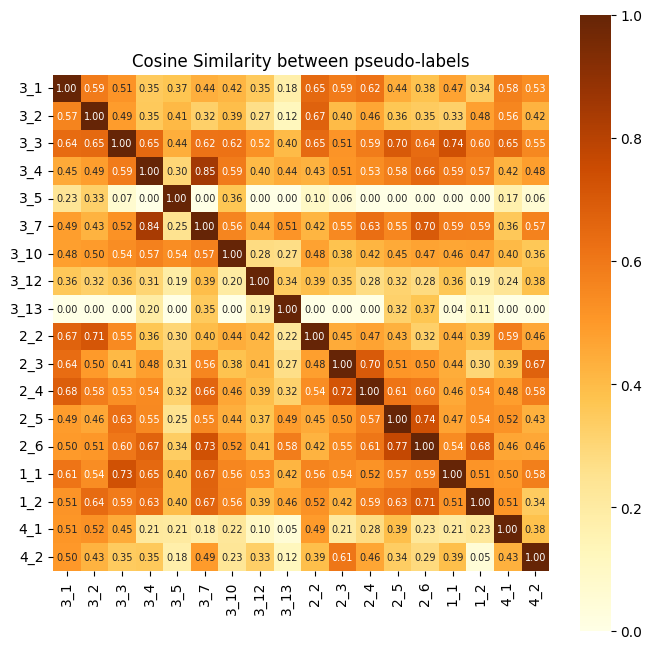

In [38]:
plt.figure(figsize=(8,8))
sns.heatmap(normalized_arr, xticklabels=labels, yticklabels=labels, cmap="YlOrBr", square=True
            , fmt=".2f",annot_kws={"size": 7},annot=True)#annot=normalized_arr[normalized_arr>=0.75].fillna(0))
plt.title("Cosine Similarity between pseudo-labels")
plt.show()

In [97]:

def cluster_embeddings(df,alg='DBSCAN', cluster_metric='cosine', eps=0.2, min_samples=5,min_size_method="median",apply_pca=False,n_components=256):
    X = np.vstack(df["embedding"].values)
    if apply_pca:
        pca = PCA(n_components)
        X = pca.fit_transform(X)
    if alg == "DBSCAN":
        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=cluster_metric).fit(X)
    elif alg == "OPTICS":
        min_c_size = calc_cluster_size(df,method=min_size_method)
        clustering = OPTICS(min_samples=min_samples, min_cluster_size=min_c_size, metric=cluster_metric, max_eps = eps).fit(X)
    elif alg == "AGG":
        clustering = AgglomerativeClustering(metric=cluster_metric,n_clusters=7, linkage="complete",distance_threshold=None).fit(X)
    else:
        clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=cluster_metric).fit(X)
    df = df.copy()
    df["person_id_cluster"] = clustering.labels_
    return df.drop(columns=["embedding"])


In [ ]:
_eps = 0.125 # 0175
_min_samples = 80 # 50
_min_size_method = "quantile" # median
_apply_pca = False # false
_n_components = 256
algs = ["OPTICS","DBSCAN","AGG"]
alg = algs[0]

tracks_df = cluster_embeddings(embeddings_df,alg = alg, 
                               eps=_eps,cluster_metric="cosine",
                               min_samples=_min_samples,min_size_method=_min_size_method,
                               apply_pca=_apply_pca,n_components=_n_components)
if "mean_embeddings" in tracks_df.columns:
    tracks_df = tracks_df.drop(columns=["mean_embeddings"])

### **Save results as .csv**

In [ ]:

detection_model = "yolov5" if model_loader == "torch" else "yolov8n" 
tracking_model = "DeepSORT"
embedding_model = "osnet_x1_0"


now = datetime.now()
date_str = now.strftime("%d-%m")
time_str = now.strftime("%H-%M")


filename = f"{detection_model}_{tracking_model}_{embedding_model}_eps{embd_eps}_cosine_{date_str}_{time_str}.csv"


final_df.to_csv(filename, index=False)
print(f"Saved results to {filename}")